# Recreating CibersortX methods

The dataset I will be using is pulled from the GSE76118 project, and was carefully chosen to only contain endothelial cells, atrial CMs, and ventricular CMs. This dataset has 1525 cells as rows, and 29466 genes as column features. I also included the identity classes as a column called ```Celltype$ident```.

In this project we will do the following steps
1. Pick \$n_{total}\$ [50,000 - 100,000] amount of cells to simulate a bulk dataset.
2. Pick a vector \$\vec{v} \in \mathbb{R}^{n_{celltypes}}\$ of proportion weights that sum to 1 where each weight represents the proportion of that celltype in the simulated dataset.
3. Sample with replacement \$\vec{v} * n_{total}\$ cells to produce a "new" single cell dataset.
4. Sum the entire expression matrix to produce a pseudo-bulk dataset composed of a known proportion of each celltype.

## Making bulk datasets from single cell data

In [1]:
suppressWarnings(suppressPackageStartupMessages({
    library(leaps)
    library(plyr)
    library(dplyr)
    library(glmnet)
    library(data.table)
    library(MASS)
    library(MCMCprecision)
    library(parallel)
    library(ggplot2)
    library(e1071)
    }))
`%!in%` <- Negate(`%in%`)

setwd("/mnt/c/Users/mkozubov/OneDrive - Tenaya Therapeutics/Desktop/Intuitions/Statistics/Linear_regression/")

count.mat <- fread('./data/example_dataset_for_classficiation_counts.csv', 
                 data.table = FALSE, 
                 check.names = FALSE, 
                 stringsAsFactors = FALSE, 
                 header = TRUE, 
                 sep = ",")
# Fixing rownames
rownames(count.mat) <- count.mat[,1]
count.mat$V1 <- NULL

# I am going to get rid of the Gm genes because I feel they pollute my results
cols.to.remove <- colnames(count.mat)[grepl("^Gm[0-9]{4,9}", colnames(count.mat))]
count.mat <- count.mat[colnames(count.mat) %!in% cols.to.remove]

# I will extract the meta data col and make it its own thing
meta.mat <- count.mat[,dim(count.mat)[2], drop=F]
meta.mat <- read.table(file = "./data//meta_data2.csv", sep=',')
celltypes <- unique(meta.mat$ident)
count.mat[,dim(count.mat)[2]] <- NULL

dim(count.mat)
dim(meta.mat)

[1]  1525 20842

[1] 1525    1

In [2]:
ntotal = round(runif(n = 1, min = 1000, max = 3000)); ntotal

[1] 1260

In [3]:
weights <- rdirichlet(1, rep(1, length(celltypes))) # ; weights <- c(0, 1, 0, 0)
names(weights) <- celltypes
ncellcount <- round(ntotal * weights)
names(ncellcount) <- celltypes
print(weights)
sum(weights)

          [,1]       [,2]      [,3]      [,4]
[1,] 0.1960546 0.05890938 0.3708179 0.3742182
attr(,"names")
[1] "aCM"               "Endothelial.Neuro" "unknown.EC"       
[4] "vCM"              


[1] 1

In [4]:
cellnames <- list()
for(i in 1:length(celltypes)){
    celltype <- celltypes[i]
    cellnames[[i]] <- sample(rownames(meta.mat[meta.mat$ident == celltype,,drop=FALSE]), ncellcount[celltype], replace = TRUE)
}
names(cellnames) <- celltypes

In [5]:
cellnames <- unlist(cellnames)

In [6]:
new.count.mat <- count.mat[cellnames,]

In [7]:
dim(new.count.mat)

[1]  1260 20842

In [8]:
pseudo.bulk.count <- round(as.matrix(apply(new.count.mat, MARGIN = 2, sum)))
colnames(pseudo.bulk.count) <- 'pseudo.bulk'
head(pseudo.bulk.count)

,pseudo.bulk
Gnai3,253523
Cdc45,142364
H19,5041409
Scml2,9916
Apoh,5
Narf,112018


## Finding DE genes in the single-cell dataset
We want to construct a signature matrix for the single-cell data like CibersortX does. I don't want to do it exactly like them yet because that sounds like a decent amount of effort. Instead I will just do a tapply with a parapply and run a wilcox DE test

### Working DE genes finder

In [9]:
# Function to perform wilcox.test for one group vs all others
wilcox_one_vs_all <- function(data, meta.data, group.by, group) {
    # Same function without variable assignments
    return( wilcox.test(data[meta.data[[group.by]] == group], 
                                    data[meta.data[[group.by]] != group], 
                                    paired = FALSE)$p.value 
          )
}

# Function to perform log2FC for one group vs all others
log2FC_one_vs_all <- function(data, meta.data, group.by, group) {
    # Same function without variable assignments
    return( log2(mean(data[meta.data[[group.by]] == group]) / mean(data[meta.data[[group.by]] != group])) )
}

In [10]:
# Parallel version of the function that takes 76.963 seconds
cl <- makeCluster(3)

system.time(
marker.list <- do.call(rbind, lapply(celltypes, FUN = function(y){ 
                clusterExport(cl = cl, varlist = c("count.mat", "meta.mat", "y", 'wilcox_one_vs_all', 'log2FC_one_vs_all'), envir=environment())
                thing <- as.data.frame(t(parApply(count.mat, MARGIN = 2, FUN = function(x){
                    return(c("p.val"  = wilcox_one_vs_all(x, meta.data = meta.mat, group.by = 'ident', group = y), 
                             "log2FC" = log2FC_one_vs_all(x, meta.data = meta.mat, group.by = 'ident', group = y),
                             "cluster" = y))
                }, 
                                                  cl = cl)))
                thing$gene <- rownames(thing)
                return(thing)
    }))
)
marker.list$p.val[is.nan(marker.list$p.val)] <- 1
marker.list$log2FC[is.nan(marker.list$log2FC)] <- 0
marker.list$p.val <- as.numeric(marker.list$p.val)
marker.list$log2FC <- as.numeric(marker.list$log2FC)

marker.list$p.val.adjust <- p.adjust(marker.list$p.val, method = "bonferroni")
marker.list$p.val.adjust.cor <- marker.list$p.val.adjust + 2.225074e-308
marker.list$sort.metric <- -log10(marker.list$p.val.adjust.cor) * sign(marker.list$log2FC)
dim(marker.list)

   user  system elapsed 
 14.250   2.101  89.366 

[1] 83368     7

In [11]:
marker.list.filt <- marker.list[marker.list$sort.metric > 0,]
dim(marker.list.filt)

[1] 7976    7

In [12]:
topMarkers3 <- marker.list.filt %>% group_by(cluster) %>% top_n(3, wt=sort.metric) %>% top_n(3, wt=log2FC)
topMarkers10 <- marker.list.filt %>% group_by(cluster) %>% top_n(10, wt=sort.metric) %>% top_n(10, wt=log2FC)
topMarkers50 <- marker.list.filt %>% group_by(cluster) %>% top_n(50, wt=sort.metric) %>% top_n(50, wt=log2FC)
topMarkers100 <- marker.list.filt %>% group_by(cluster) %>% top_n(200, wt=sort.metric) %>% top_n(200, wt=log2FC)
topMarkers3

p.val,log2FC,cluster,gene,p.val.adjust,p.val.adjust.cor,sort.metric
<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1.366971e-128,1.562893,aCM,Myl7,1.125345e-123,1.125345e-123,122.94871
8.349411e-191,4.862432,aCM,Vsnl1,6.873569e-186,6.873569e-186,185.16282
1.020383e-137,3.707410,aCM,Nr2f1,8.400198e-133,8.400198e-133,132.07571
3.831746e-88,1.519350,Endothelial.Neuro,Cd34,3.154447e-83,3.154447e-83,82.50108
7.347883e-88,2.082359,Endothelial.Neuro,Igf1,6.049071e-83,6.049071e-83,82.21831
7.410803e-91,1.671877,Endothelial.Neuro,Mmp2,6.100869e-86,6.100869e-86,85.21461
5.852406e-146,3.876227,unknown.EC,Icam2,4.817934e-141,4.817934e-141,140.31714
4.882118e-152,3.909183,unknown.EC,Cdh5,4.019155e-147,4.019155e-147,146.39587
2.185582e-150,3.995886,unknown.EC,Plvap,1.799259e-145,1.799259e-145,144.74491


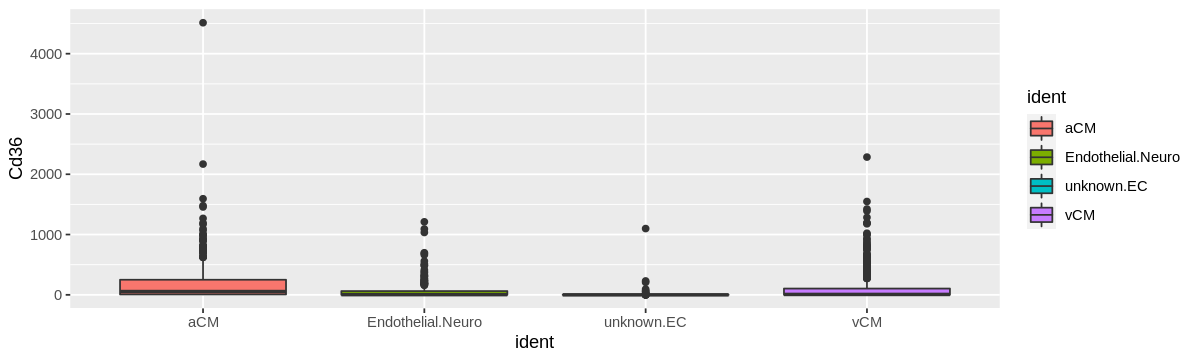

In [13]:
options(repr.plot.height=3, repr.plot.width = 10)
ggplot(cbind(count.mat, meta.mat), aes(x = ident, y = !!sym("Cd36"), fill = ident)) + geom_boxplot()

## Fitting a v-SVM to the signature matrix
I believe what the authors of CibersortX do next is fit a v-SVM implemented in ```library(e1071)``` package

In [16]:
genes.to.go.forward.with <- topMarkers100$gene[topMarkers100$gene %in% rownames(pseudo.bulk.count)] # gotta make sure that the genes are in the dataset

# Works in the idealized case
x = count.mat[,genes.to.go.forward.with] 
x = x / apply(x, 1, sum) * 1e6
x.test = pseudo.bulk.count[genes.to.go.forward.with,"pseudo.bulk"]
x.test = x.test / sum(x.test) * 1e6

# See if this works with my TT034 data
# x = count.mat
# x = x / apply(x, 1, sum) * 1e6
# x = x[,genes.to.go.forward.with]
# x.test = pseudo.bulk.count
# x.test = x.test / sum(x.test) * 1e6
# x.test = x.test[genes.to.go.forward.with,"pseudo.bulk"]

as.data.frame(t(apply(x[genes.to.go.forward.with], MARGIN = 2, mean)))
as.data.frame(t(x.test[genes.to.go.forward.with]))

Tbx2,Cnn1,Tcea3,Gstt1,Nr1h3,Zim1,Ndufa11,Cd36,Mmd,Crabp2,⋯,Myh7b,Inafm2,Hmga1b,Hsp25.ps1,Cpt1b,Trim71,Ldha.ps2,MattUnknown338,Mhrt,Kctd12
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
13.28147,1181.004,137.4505,48.73407,26.29506,64.86357,1556.831,272.1299,308.7545,64.08916,⋯,99.93344,634.3314,125.4315,14.47627,99.80975,603.013,10.68392,20.78275,37.27154,83.15424


Tbx2,Cnn1,Tcea3,Gstt1,Nr1h3,Zim1,Ndufa11,Cd36,Mmd,Crabp2,⋯,Myh7b,Inafm2,Hmga1b,Hsp25.ps1,Cpt1b,Trim71,Ldha.ps2,MattUnknown338,Mhrt,Kctd12
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
8.480102,1006.27,108.1486,41.87328,20.06904,47.05063,1384.442,208.4513,260.6995,51.04827,⋯,81.73057,623.4309,119.9375,11.98486,86.71399,516.1994,10.06785,16.9703,28.78346,71.35567


In [17]:
cellprop.estimate <- list()
beta.list <- list()
rho.list <- list()

for(i in 1:length(celltypes)){
    celltype <- celltypes[i]
    group = factor(ifelse(meta.mat$ident == celltype, celltype, 'other'), levels = c(celltype, 'other'), ordered = T)
    svmfit = svm(x = x, y = group, kernel = "linear", cost = 0.1, nu = 0.2, scale = FALSE, type = 'nu-classification')
    beta = drop(t(svmfit$coefs)%*%as.matrix(x[svmfit$index,]))
    beta0 = svmfit$rho
    beta.list[[i]] <- beta
    rho.list[[i]] <- beta0
    cellprop.estimate[[i]] <- as.numeric((beta %*% x.test)) - as.numeric(beta0)# 
}
names(rho.list) <- celltypes
rho.list <- unlist(rho.list)
names(beta.list) <- celltypes
beta.list <- as.data.frame(beta.list)
names(cellprop.estimate) <- celltypes

### Looking into the inner workings of the SVM
If we pull out the betas and intercepts, we can actually use them almost like PCA loadings. When we cross them will the training and input dataset, we can generate a 3-column dataframe that will represent the linear cuts through feature space and how the model classifies the cells.

For some reason I don't understand, we need to subtract the y-intercept (rho) instead of adding it????

Plotting the components of my SVM output crossed with my data shows us how the model has cut up the features space, and positive values mean the model classifies these cells as celltypeA for each principle component.

In [18]:
svm.loadings <- as.matrix(x) %*% as.matrix(beta.list) 
svm.loadings <- t(apply(svm.loadings, MARGIN = 1, function(x){ x - rho.list}))
pseudo.bulk.svm.loading <- t(x.test) %*% as.matrix(beta.list) - rho.list

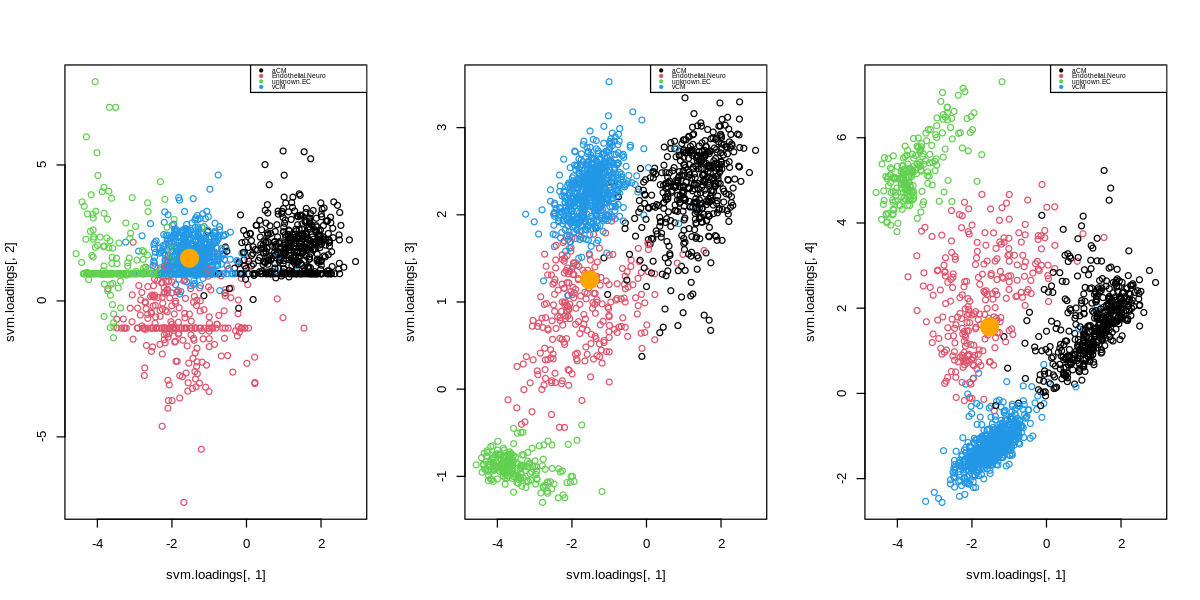

In [22]:
options(repr.plot.height=5, repr.plot.width = 10)
group = factor(meta.mat$ident)
par(mfrow = c(1,3))
plot(svm.loadings[,1], 
     svm.loadings[,2], 
     col = group)
points(pseudo.bulk.svm.loading[,1], 
       pseudo.bulk.svm.loading[,2], 
       col = 'orange', pch = 19, cex = 3)
legend("topright", legend = levels(group), col = 1:length(levels(group)), pch = 19, cex = 0.5)

plot(svm.loadings[,1], 
     svm.loadings[,3], 
     col = group)
points(pseudo.bulk.svm.loading[,1], 
       pseudo.bulk.svm.loading[,3], 
       col = 'orange', pch = 19, cex = 3)
legend("topright", legend = levels(group), col = 1:length(levels(group)), pch = 19, cex = 0.5)

plot(svm.loadings[,1], 
     svm.loadings[,4], 
     col = group)
points(pseudo.bulk.svm.loading[,1], 
       pseudo.bulk.svm.loading[,4], 
       col = 'orange', pch = 19, cex = 3)
legend("topright", legend = levels(group), col = 1:length(levels(group)), pch = 19, cex = 0.5)

### Calculating centroids of cell clusters

In [24]:
A <- t(apply(svm.loadings, MARGIN = 2, function(x) tapply(x, group, mean))); rownames(A) <- paste0(rownames(A), "_SVM"); A

,aCM,Endothelial.Neuro,unknown.EC,vCM
aCM_SVM,1.220542,-1.7110141,-3.485664,-1.458574
Endothelial.Neuro_SVM,1.937852,-0.7662589,1.523115,1.617981
unknown.EC_SVM,2.277637,0.9067348,-0.890439,2.274213
vCM_SVM,1.632291,2.2166713,5.251111,-1.215645


### How to actually get cell proportions
Now that we are in SVM space, I believe the way I would set up the problem is that the mixture (bulk) sample is some linear combination of the celltypes I provided. Therefore, we would calculate the centroids of each of my celltype populations in this SVM space, and set up a problem like this where we just solve for what poportion of each it takes to create the mixture.

$$ {\left\lbrack 
        \begin{matrix}
            aCM_{1,1} & EN_{1,2} & vCM_{1,3} \\
            aCM_{2,1} & EN_{2,2} & vCM_{2,3} \\
            aCM_{3,1} & EN_{3,2} & vCM_{3,3}
         \end{matrix}\right\rbrack} 
= \left\lbrack \matrix{M_{1,1}\\
                       M_{2,1}\\
                       M_{3,1}} \right\rbrack
$$
Solving for aCM, EN, and vCM should give us the linear combination of my 3 class centroids it would take to create the mixture model.

In [21]:
# A <- matrix(c(1.75, 3.5, -1.75, 
#               1.75, -4, 0.5, 
#               2, 6, -1.5), nrow = 3, byrow = TRUE)

# Vector of constants
b <- as.numeric(pseudo.bulk.svm.loading)

pred.cell.prop <- solve(A, b)
(pred.cell.prop / sum(pred.cell.prop))
weights

aCM Endothelial.Neuro        unknown.EC               vCM 
       0.21772049        0.04375805        0.30758595        0.43093551

0.1960546,0.05890938,0.3708179,0.3742182


# To-do
1. TT034 single nucleus CM proportions
    1. Downsample TT034 single nucleus CMs count matrix to 500 cells per subcellstate (2000 cells total). 
    1. Download the bulk TT034 TPM matrix.
    1. Download the downsampled CMs.
    1. Go through my CibersortX method and observe CM0 and CM1/CM3. I'm concerned that lack of clearly defined markers will make it difficult for the SVM to properly seperate out that class. We will see at the 'PCA' stage if the SVM is doing a good job seperating classes and if there is any unexplained variability.
1. TT034 all celltype proportions
    1. Downsample TT034 single nucleus all celltypes count matrix to 500 cells per celltype (CM, EC, FB, Immune, mural, Endocardial)
    1. Run through the gauntlet
1. Benchmark mixture with celltype missing from signature matrix
    1. Make a mixture from all celltypes
    1. Find DE genes only considering aCM, vCM
    1. Build model only considering aCM, vCM
    1. Observe deconvolution